## 实验六：TBE算子开发与集成

基于TBE算子开发语言开发运行在AI Core上的自定义算子，并对自定义开发的算子进行性能测试。另
外，将自定义开发的算子注册至算子库，在基于算子库构建 VGG16 神经网络时能够运行自定义开发的算
子。

### 1. 实验目的
- 基于TBE算子开发语言开发运行在AI Core上的自定义算子，并对自定义开发的算子进行性能测试。
- 将自定义开发的算子注册至算子库，在基于算子库构建VGG17神经网络时能够运行自定义开发的算子。

### 2. 实验内容
TBE算子支持三种开发方式，三种方式的特点如下，均能得到相同的算子工程目录结构：

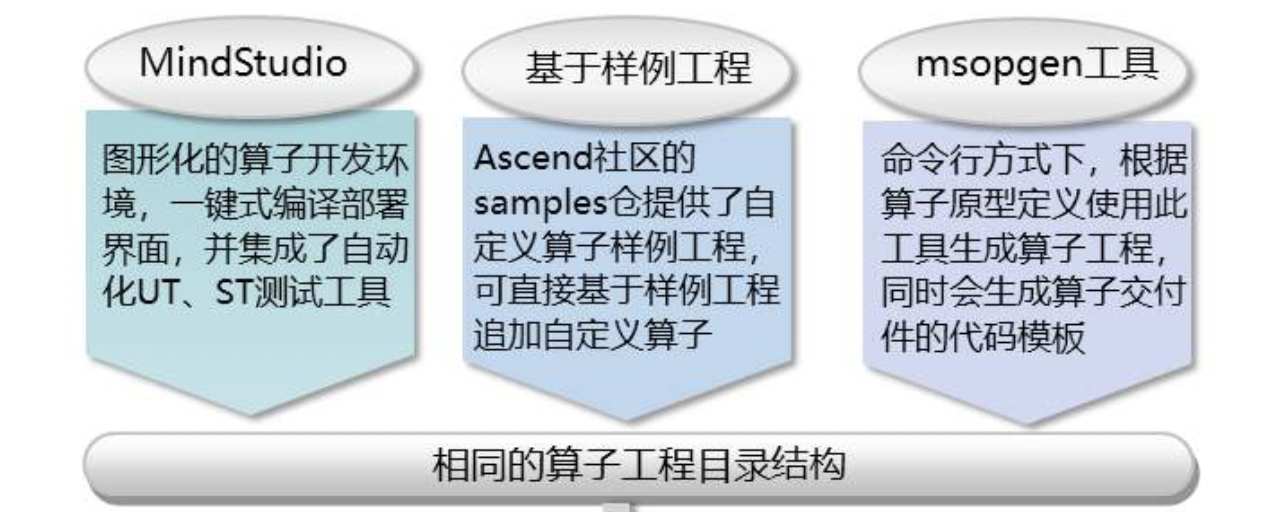

为了让同学更直观的接触算子开发的每个流程，本次实验我们不采用MindStudio工具开发，而是基于msopgen工具这种方式分别完成Softmax算子和BatchNormalization算子的开发。mspogen根是了自定义算子工程生成工具，可基于算子原型定义输出算子开发相关交付件，包括算子代码实现文件、算子适配插件、算子原型定义、算子信息定义以及工程编译配置文件。\
本次实验不涉及任何第三方框架的适配，仅开发纯Ascend算子。我们仅使用msopgen工具生成工程。由于msopgen的命令必须指定框架，这里在命令里指定tensorflow框架，但不做任何第三方框架的适配开发。

### 3. 实验环境

- 环境：ModelArts弹性云服务器，包含x86_64CPU和昇腾310推理芯片
- 操作系统：Ubuntu

| 依赖   | 版本   |
| ------ | ------ |
| c++    | 7.5.0  |
| cmake  | 3.10.2 |
| python | 3.7.5  |

### 4. BatchNormalization算子开发


### 4.1 算子原型

BatchNormalization算子原型如下：



#ifndef GE_OP_BATCH_NORMALIZATION_DSL_H \
#define GE_OP_BATCH_NORMALIZATION_DSL_H \
#include "graph/operator_reg.h" \

namespace ge {

REG_OP(BatchNormalizationDSL) \
    .INPUT(x, TensorType({DT_FLOAT,DT_FLOAT16})) \
    .INPUT(scale, TensorType({DT_FLOAT,DT_FLOAT})) \
    .INPUT(offset, TensorType({DT_FLOAT,DT_FLOAT})) \
    .INPUT(mean, TensorType({DT_FLOAT,DT_FLOAT})) \
    .INPUT(variance, TensorType({DT_FLOAT,DT_FLOAT})) \
    .OUTPUT(y, TensorType({DT_FLOAT,DT_FLOAT16})) \
    .OUTPUT(batch_mean, TensorType({DT_FLOAT,DT_FLOAT})) \
    .OUTPUT(batch_variance, TensorType({DT_FLOAT,DT_FLOAT})) \
    .REQUIRED_ATTR(epsilon, Float) \
    .REQUIRED_ATTR(is_training, Bool) \
    .OP_END_FACTORY_REG(BatchNormalizationDSL) \
}

#endif //GE_OP_BATCH_NORMALIZATION_DSL_H



算子函数实现：

通过调用TBE DSL接口，在算子工程下的“tbe/impl/batch_normalization_dsl.py”文件中进行
BatchNormalizationDSL算子的实现，主要包括算子函数定义、算子入参校验、compute过程实现及调度与编译。

In [3]:
from tbe import tvm
from tbe.common.register import register_op_compute
import te.lang.cce as tbe
import te.platform as tbe_platform
from te.utils import para_check
from te.utils import shape_util


def _output_data_y_compute(x, mean, variance, scale, offset, epsilon):
    # x = (x - mean)/(var + epsilon)**0.5
    # y = scale*x + offset
    shape_x = shape_util.shape_to_list(x.shape)
    y_add = tbe.vadds(variance, epsilon)
    y_sqrt = tbe.vsqrt(y_add)
    var_sub = tbe.vsub(x, mean)
    y_norm = tbe.vdiv(var_sub, y_sqrt)
    scale_broad = tbe.broadcast(scale, shape_x)
    offset_broad = tbe.broadcast(offset, shape_x)
    res = tbe.vadd(tbe.vmul(scale_broad, y_norm), offset_broad)

    return res


def _batch_norm_dsl_train_compute(x, scale, offset, epsilon):
    # 如果输入x的dtype为float16，则转为float32进行计算, 防止训练的时候下溢造成训练困难
    is_cast = False
    if x.dtype == "float16" and tbe_platform.cce_conf.api_check_support("te.lang.cce.vdiv", "float32"):
        is_cast = True
        x = tbe.cast_to(x, "float32")

    shape_x = shape_util.shape_to_list(x.shape)

    axis = [0, 2, 3]    # NHW
    num = shape_x[0]*shape_x[2]*shape_x[3]
    num_rec = 1.0/num

    # 根据 x 的维度 C 计算均值
    mean_sum = tbe.sum(x, axis, True)
    mean_muls = tbe.vmuls(mean_sum, num_rec)
    mean_broadcast = tbe.broadcast(mean_muls, shape_x)

    # 根据 x 的维度 C 计算方差
    var_sub = tbe.vsub(x, mean_broadcast)
    var_mul = tbe.vmul(var_sub, var_sub)
    var_sum = tbe.sum(var_mul, axis, True)
    var_muls = tbe.vmuls(var_sum, num_rec)
    var_broadcast = tbe.broadcast(var_muls, shape_x)

    # BatchNormalization 计算
    res_y = _output_data_y_compute(x, mean_broadcast, var_broadcast, scale, offset, epsilon)

    # 保持输入输出的dtype一致
    if is_cast:
        res_y = tbe.cast_to(res_y, "float16")

    # 计算当前batch的均值和方差 NCHW -> C
    res_batch_mean = tbe.vmuls(mean_sum, num_rec)
    if num == 1:
        batch_var_scaler = 0.0
    else:
        batch_var_scaler = float(num)/(num - 1)
    res_batch_var = tbe.vmuls(var_muls, batch_var_scaler)
    res = [res_y, res_batch_mean, res_batch_var]
    return res


def _batch_norm_dsl_inf_compute(x, scale, offset, mean, variance, epsilon):
    # 如果输入x的dtype为float16，则转为float32进行计算
    is_cast = False
    if x.dtype == "float16" and tbe_platform.cce_conf.api_check_support("te.lang.cce.vdiv", "float32"):
        is_cast = True
        x = tbe.cast_to(x, "float32")
    shape_x = shape_util.shape_to_list(x.shape)

    # 将已有的均值和方差广播至同纬度
    mean_broadcast = tbe.broadcast(mean, shape_x)
    var_broadcast = tbe.broadcast(variance, shape_x)

    # BatchNormalization 计算
    res_y = _output_data_y_compute(x, mean_broadcast, var_broadcast, scale, offset, epsilon)

    # 保持输入输出的dtype一致
    if is_cast:
        res_y = tbe.cast_to(res_y, "float16")

    # 推理的batch_mean和batch_var 即为传入的mean和variance
    scaler_zero = 0.0
    res_batch_mean = tbe.vadds(mean, scaler_zero)
    res_batch_var = tbe.vadds(variance, scaler_zero)
    res = [res_y, res_batch_mean, res_batch_var]
    return res


@register_op_compute("batch_normalization_dsl")
def batch_normalization_dsl_compute(x, scale, offset, mean, variance, y, batch_mean, batch_variance, epsilon, is_training, kernel_name="batch_normalization_dsl"):
    if is_training:     # 训练时，均值和方差根据样本计算得到
        res = _batch_norm_dsl_train_compute(x, scale, offset, epsilon)
    else:               # 推理时，均值和方差需要传入
        res = _batch_norm_dsl_inf_compute(x, scale, offset, mean, variance, epsilon)
    return res


@para_check.check_op_params(para_check.REQUIRED_INPUT, para_check.REQUIRED_INPUT, para_check.REQUIRED_INPUT, para_check.OPTION_INPUT, para_check.OPTION_INPUT, para_check.REQUIRED_OUTPUT, para_check.REQUIRED_OUTPUT, para_check.REQUIRED_OUTPUT, para_check.OPTION_ATTR_FLOAT, para_check.REQUIRED_ATTR_BOOL, para_check.KERNEL_NAME)
def batch_normalization_dsl(x, scale, offset, mean, variance, y, batch_mean, batch_variance, epsilon, is_training, kernel_name="batch_normalization_dsl"):
    """
    x: 输入张量(N,C1,H,W,C0)
    scale: 缩放量(C1*C0,)
    offset: 偏移量(C1*C0,)
    mean: 均值(C1*C0,)
    variance: 方差(C1*C0,)
    y: 输出张量(N,C1,H,W,C0)
    batch_mean: 当前张量的均值(C1*C0,)
    batch_variance: 当前张量的方差(C1*C0,)
    epsilon: 防止方差为0导致除数为0
    is_training: 训练验证开关
    kernel_name: 算子名称
    """
    # 检查输入的dtype和shape
    shape_x = x.get("shape")
    dtype_x = x.get("dtype")
    para_check.check_shape(shape_x, param_name="x")
    para_check.check_dtype(dtype_x.lower(), ("float16", "float32"), param_name="x")

    dtype_scale = scale.get("dtype")
    dtype_offset = offset.get("dtype")
    para_check.check_dtype(dtype_scale.lower(), ("float32", "float16"), param_name="scale")
    para_check.check_dtype(dtype_offset.lower(), ("float32", "float16"), param_name="offset")
    if not is_training:
        dtype_mean = mean.get("dtype")
        dtype_variance = variance.get("dtype")
        para_check.check_dtype(dtype_mean.lower(), ("float32", "float16"), param_name="mean")
        para_check.check_dtype(dtype_variance.lower(), ("float32", "float16"), param_name="variance")

    # (C1*C0,) -> (1,C1,1,1,C0)
    shape_scale = [1, shape_x[1], 1, 1, shape_x[4]]
    shape_offset = shape_scale
    if not is_training:
        shape_mean = shape_scale
        shape_variance = shape_scale

    # 构建输入节点, 使用TVM的placeholder接口对输入tensor进行占位，返回tensor对象
    data_x = tvm.placeholder(shape_x, dtype=dtype_x.lower(), name="data_x")
    data_scale = tvm.placeholder(shape_scale, dtype=dtype_scale.lower(), name="data_scale")
    data_offset = tvm.placeholder(shape_offset, dtype=dtype_offset.lower(), name="data_offset")
    if is_training:
        data_mean, data_variance = None, None
    else:
        data_mean = tvm.placeholder(shape_mean, dtype=dtype_mean, name="data_mean")
        data_variance = tvm.placeholder(shape_variance, dtype=dtype_variance, name="data_variance")

    # BatchNormalization计算
    res = batch_normalization_dsl_compute(data_x, data_scale, data_offset, 
                                          data_mean, data_variance, y, 
                                          batch_mean, batch_variance, epsilon, 
                                          is_training, kernel_name)

    # 自动调度
    with tvm.target.cce():
        schedule = tbe.auto_schedule(res)

    if is_training:
        tensor_list = [data_x, data_scale, data_offset] + list(res)
    else:
        tensor_list = [data_x, data_scale, data_offset,
                       data_mean, data_variance] + list(res)

    # 编译配置
    config = {"name": kernel_name,
              "tensor_list": tensor_list}
    tbe.build(schedule, config)


### 4.2 配置算子信息库
算子信息库的路径为“tbe/op_info_cfg/ai_core/ascend310/batch_normalization_dsl.ini”，包含了算子
的类型，输入输出的名称、数据类型、数据排布格式等信息，msopgen工具已经根据
batch_normalization_dsl.json文件将上述内容自动填充，开发者无需修改。

### 4.3 实验运行

    # 激活环境
    ! source /usr/local/Ascend/ascend-toolkit/set_env.sh
    # 1.工程创建
    ! /usr/local/Ascend/ascend-toolkit/latest/python/site-packages/bin/msopgen gen -i /root/EXP/exp6/batch_normalization_dsl.json -f tf -c ai_core-Ascend310 -out /root/EXP/exp6/BatchNormalizationDSL 
    # 切换工程目录 
    ! cd BatchNormalizationDS

    # 2.算子开发 
    # 2.1 定义算子原型文件 
    vim op_proto/batch_normalization_dsl.cc 

    # 2.2 算子函数实现 
    vim tbe/impl/batch_normalization_dsl.py 

    # 3.算子编译部署 

    chmod 775 build.sh vim build.sh 
    # 配置算子编译所需环境变量 
    ./build.sh 


    # 编译 
    ./build_out/custom_opp_ubuntu_x86_64.run 


    # 部署 
    # 切换工程目录 
    cd .. 


    # 设置环境变量 
    source env_npu.sh 


    # 4.测试 
    # 推理测试用例 
    /usr/local/Ascend/ascend-toolkit/latest/python/site-packages/bin/msopst run -i /root/EXP/exp6/test_batch_normalization_dsl.json -soc Ascend310 -out /root/EXP/exp6/out 
    # 训练测试用例 
    /usr/local/Ascend/ascend-toolkit/latest/python/site-packages/bin/msopst run -i /root/EXP/exp6/test_batch_normalization_dsl2.json -soc Ascend310 -out /root/EXP/exp6/out


### 5. Softmax算子开发

### 5.1 算子原型

 算子原型定义了算子的数学含义：包含算子的输入、输出、属性信息；算子参数的校验和shape的推
导。定义好的算子被注册到算子原型库中。


#ifndef GE_OP_SOFTMAX_H \
#define GE_OP_SOFTMAX_H \
#include "graph/operator_reg.h"

namespace ge {

REG_OP(Softmax) \
    .INPUT(x, TensorType({DT_FLOAT,DT_FLOAT16})) \
    .OUTPUT(y, TensorType({DT_FLOAT,DT_FLOAT16})) \
    .ATTR(axis, ListInt, {-1}) \
    .OP_END_FACTORY_REG(Softmax) \
}

#endif //GE_OP_SOFTMAX_H


### 5.2 算子函数实现

通过调用TBE DSL接口，在算子工程下的“tbe/impl/softmax.py”文件中进行softmax算子的实现，主要
包括算子函数定义、算子入参校验、compute过程实现及调度与编译

In [4]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-

"""
softmax
"""

from __future__ import absolute_import
import tbe
from te.utils import shape_util
import te.tvm as tvm
import te.lang.cce
import te.platform as tbe_platform
from te.utils import para_check     # 提供了通用的算子参数校验接口
from te.utils import shape_util




# 其作用是整网运行时，支持算子做UB自动融合，使得算子在UB中根据UB融合规则自动与其他算子的compute进行拼接，提升算子运行效率,，若算子实现逻辑中涉及reshape操作，不可使用此装饰器函数
@tbe.common.register.register_op_compute("Softmax")
def softmax_compute(input_x, output_y, axis=-1, kernel_name="softmax"):
    """
    softmax:
        input_x: 算子的输入tensor，每个tensor需要采用字典的形式进行定义，包含shape、ori_shape、format、ori_format与dtype信息，用于计算Softmax函数的Tensor，数据类型为float16或float32。
        output_y: 算子的输出tensor，包含shape和dtype等信息，字典格式，数据类型和shape与 x 相同，取值范围为[0, 1]。
        axis: 指定Softmax运算的轴axis，假设输入 x 的维度为x.ndim，则axis的范围为 [-x.ndim, x.ndim) ，-1表示最后一个维度。默认值：-1。
        kernel_name: 算子在内核中的名称
    """
    dtype = input_x.dtype.lower()
    shape = input_x.shape
    has_improve_precision = False


    # 分子 e^x
    data_exp = te.lang.cce.vexp(input_x)

    # 对于输入数据类型为float16的来说，可以先广播到float32，做以下的除法操作，再转为数据类型float16，用于提升计算精度
    tbe_product = tbe_platform.cce_conf.get_soc_spec("SOC_VERSION")
    if data_exp.dtype == "float16" and tbe_product in ("Ascend310",):
        data_exp = te.lang.cce.cast_to(data_exp, "float32")
        has_improve_precision = True

    # sum(e^x) 分母，将分母也广播到shape大小
    data_expsum = te.lang.cce.sum(data_exp, axis, keepdims=True)
    data_expsum = te.lang.cce.broadcast(data_expsum, shape)

    # e^x/sum(e^x)
    output = te.lang.cce.vdiv(data_exp, data_expsum)

    #转为数据类型为float16
    if has_improve_precision and dtype == "float16":
        output = te.lang.cce.cast_to(output, "float16")

    return output


# 对算子的输入、输出、属性及Kernel Name进行基础校验
@para_check.check_op_params(para_check.REQUIRED_INPUT, para_check.REQUIRED_OUTPUT,
                            (para_check.OPTION_ATTR_INT, para_check.OPTION_ATTR_LIST_INT), para_check.KERNEL_NAME,
                            para_check.OPTION_ATTR_STR)
def softmax(input_x, output_y, axis=-1, kernel_name="softmax"):
    """
    softmax:
    ----------
    input_x : dict
    format: ND
    dtype:  float16, float32
    output_y: dict，shape和dtype应该和input_x一样
    axis : Intlist
    kernel_name : str，这里为softmax
    Returns
    -------
    None
    """

    # 获取算子输入tensor的shape以及dtype，为后续定义输入tensor的张量占位符做准备。
    shape = input_x.get("shape")
    dtype = input_x.get("dtype").lower()
    axis=list(axis)

    # 基本校验
    para_check.check_shape(shape, param_name="x")
    para_check.check_dtype(dtype.lower(), ("float16", "float32"), param_name="x")

    axis = shape_util.axis_check(len(shape), axis)  # 对轴的值进行合法性校验，并返回排好序且是正数的轴值，轴值按照升序进行排序

    shape, axis = shape_util.shape_refine(list(shape), axis)  # recude dim=1 的轴
    shape, axis = shape_util.simplify_axis_shape(shape, axis) # 把连续的reduce轴进行合并，并把对应的shape的维度也进行合并

    data_x = tvm.placeholder(shape, dtype=dtype, name="data_x")

    with tvm.target.cce():
        output = softmax_compute(data_x, output_y, axis, kernel_name)
        result = tbe.dsl.auto_schedule(output)  # 调用auto_schedule接口，便可以自动生成算子相应的调度

    tensor_list = [data_x, output]
    # TVM的打印机制；可以看到相应计算的中间表示。配置信息包括是否需要打印IR、是否编译以及算子内核名以及输入、输出张量
    config = {"name": kernel_name,
                "tensor_list": tensor_list}

    tbe.dsl.build(result, config)



算子信息库的路径为“tbe/op_info_cfg/ai_core/ascend310/softmax.ini”，包含了算子的类型，输入输出
的名称、数据类型、数据排布格式等信息，msopgen工具已经根据softmax.json文件将上述内容自动填充，开发者无需修改。

### 6. 实验运行

    # TODO 学生需要按照指令操作的部分 
    # 请按照以下指令和上述操作过程，顺利完成算子开发 
    # 1.激活环境 
    source /usr/local/Ascend/ascend-toolkit/set_env.sh 

    # 切换工程目录 
    cd Softmax 

    # 2.算子开发 
    # 2.1 定义算子原型文件 
    vim op_proto/softmax.cc 

    # 2.2 算子函数实现 
    vim tbe/impl/softmax.py 

    # 3.算子编译部署 
    chmod 775 build.sh vim build.sh 

    # 配置算子编译所需环境变量 
    ./build.sh 

    # 编译 
    ./build_out/custom_opp_ubuntu_x86_64.run 

    # 部署 
    # 切换工程目录 
    cd .. 

    # 设置环境变量 
    source env_npu.sh 

    # 4.测试 
    # 推理测试用例 
    /usr/local/Ascend/ascend-toolkit/latest/python/site-packages/bin/msopst run -i ./test_softmax_case.json -soc Ascend310 -out ./out



